This notebook implements a biomechanical primate model arm used in the following works:

- "Iterative Linear Quadratic Regulator Design for Nonlinear Biological Movement Systems."
W. Li and E. Todorov, International Conference on Informatics in Control (2004)

- "Preference Distributions of Primary Motor Cortex Neurons Reflect Control Solutions Optimized for Limb Biomechanics."
T. Lillicrap and S. Scott, Neuron (2013)

- "Population subspaces reflect movement intention for arm and brain-machine interface control."
H. Lalazar, J.M. Murray, L.F. Abbott, E. Vaadia, BioRxiv (2019)

One feature added to the original model in the last reference above and here is the inclusion of gravitational force and the option to have the arm move on an inclined plane rather than in the horizontal plane (determined by the parameter `phi_incline` below.)

--

JM Murray, University of Oregon

https://murraylab.uoregon.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Arm:
    '''
    A biomechanical model arm, as used by Li & Todorov and Lillicrap & Scott, with a method for updating it
    given a muscle command.
    
    Parameters
    ----------
    x0, y0 : The initial position of the hand (should be within the reach area boundaries).
    '''
    def __init__(self, x0=-0.1, y0=0.25):
        # The boundaries of the reach area (in meters, where (0,0) is the location of the shoulder joint):
        self.x_min = -0.275
        self.x_max = 0.075
        self.y_min = 0.025
        self.y_max = 0.375
        
        # Duration of timestep, in seconds:
        self.dt = 0.01
        
        # Parameters from Lillicrap and Scott:
        self.beta = 1.55
        self.omega = 0.81
        self.rho = 2.12
        self.vMax = -7.39
        self.cV0 = -3.21
        self.cV1 = 4.17
        self.bV = 0.62
        self.aV0, self.aV1, self.aV2 = -3.12, 4.21, -2.67
        self.ell1 = 0.145  # length of upper arm in meters
        self.ell2 = 0.284  # length of forearm in meters
        self.m1 = 0.2108  # mass of upper arm in kg
        self.m2 = 0.1938  # mass of forearm in kg
        self.g_grav = 9.8  # gravitational acceleration in m/s^2 (relevant only if plane of motion is inclined)
        self.phi_incline = 0  # incline of the plane of motion (in radians; 0 corresponds to horizontal, as in the original model)
        self.i1 = 0.025
        self.i2 = 0.045
        self.c1 = 0.0749
        self.c2 = 0.0757
        self.a1 = self.i1 + self.i2 + self.m2*self.ell1**2
        self.a2 = self.m2*self.ell1*self.c1
        self.m = np.array([[2, -2, 0, 0, 1.5, -2], [0, 0, 2, -2, 2, -1.5]])
        self.theta0 = np.array([[15.0, 4.88, 0, 0, 4.5, 2.12], [0, 0, 80.86, 109.32, 92.96, 91.52]])*2*np.pi/360
        self.ell0 = np.array([7.32, 3.26, 6.4, 4.26, 5.95, 4.04])
        self.b = np.array([[0.05, 0.025], [0.025, 0.05]])  # from Li and Todorov, Eq. (23)

        # joint angles for shoulder and elbow:
        self.theta1 = np.arctan2(y0, x0) - np.arccos((x0**2 + y0**2 + self.ell1**2 - self.ell2**2)
                                                     /(2*self.ell1*(x0**2 + y0**2)**0.5))
        self.theta2 = np.arccos((x0**2 + y0**2 - self.ell1**2 - self.ell2**2)/(2*self.ell1*self.ell2))

        # joint angular velocities:
        self.omega1 = 0
        self.omega2 = 0
        
        # Cartesian hand coordinates:
        self.z = np.array([x0, y0])
        
        if False:
            # Compute the det(Jacobian) of initial velocity w.r.t. initial muscle commands:
            ell = 1 + self.m[0,:]*(self.theta0[0,:] - self.theta1)/self.ell0 + self.m[1,:]*(self.theta0[1,:] - self.theta2)/self.ell0
            m_theta = np.array([[self.a1 + 2*self.a2*np.cos(self.theta2), self.i2 + self.a2*np.cos(self.theta2)], 
                                [self.i2 + self.a2*np.cos(self.theta2), self.i2]])
            domega_du = np.dot(inv(m_theta), self.m)*self.f(ell)
            dv1_du = -ell[0]*np.sin(self.theta1)*domega_du[0,:]
            dv1_du += -ell[1]*np.sin(self.theta1 + self.theta2)*(domega_du[0,:] + domega_du[1,:])
            dv2_du = ell[0]*np.cos(self.theta1)*domega_du[0,:]
            dv2_du += ell[1]*np.cos(self.theta1 + self.theta2)*(domega_du[0,:] + domega_du[1,:])
            dv_du = np.array([dv1_du, dv2_du])
            det_jac = det(dv_du)

    def f(self, x, xdot):
        '''
        Given the muscle lengths and their derivatives, this function is used for computing the joint torques.
        '''
        foo = np.zeros(6)
        for ii in range(6):
            bar = abs((x[ii]**self.beta - 1)/self.omega)
            bar = 10*np.tanh(bar/10)
            # The tanh in these expressions prevents exponential overflow when x is too large:
            if xdot[ii] <= 0:
                foo[ii] = np.exp(bar)*(self.vMax - xdot[ii])/(self.vMax + (self.cV0 + self.cV1*x[ii])*xdot[ii])
            else:
                foo[ii] = np.exp(bar)*(self.bV - (self.aV0 + self.aV1*x[ii] + self.aV2*x[ii]**2)*xdot[ii])/(self.bV + xdot[ii])
            
        return foo

    def forward(self, u):
        '''
        Advance the arm by one timestep. Input u is a 6D vector of muscle commands, which should be nonnegative.
        '''        
        ell = 1 + self.m[0,:]*(self.theta0[0,:] - self.theta1)/self.ell0 + self.m[1,:]*(self.theta0[1,:] - self.theta2)/self.ell0
        ell = 0.5*(abs(ell) + ell)  # muscle length should be positive
        elldot = -self.m[0,:]*self.omega1/self.ell0 - self.m[1,:]*self.omega2/self.ell0  # Note: Sign differs from Lillicrap & Scott
               
        # torque due to gravity:
        tau_g = np.array([-0.5*self.m1*self.g_grav*self.ell1*np.sin(self.phi_incline)*np.cos(self.theta1), 
                       -0.5*self.m2*self.g_grav*self.ell2*np.sin(self.phi_incline)*np.cos(self.theta1 + self.theta2)])
        
        # torque due to muscle activations:
        tau = np.dot(self.m, u*self.f(ell, elldot))
        
        # Update the state of the arm:
        m_theta = np.array([[self.a1 + 2*self.a2*np.cos(self.theta2), self.i2 + self.a2*np.cos(self.theta2)], 
                            [self.i2 + self.a2*np.cos(self.theta2), self.i2]])
        m_theta_inv = np.linalg.inv(m_theta)
        c = self.a2*np.sin(self.theta2)*np.array([-self.omega2*(2*self.omega1 + self.omega2), self.omega2**2])
        rhs = np.append(np.array([self.omega1, self.omega2]), 
                        np.dot(m_theta_inv, tau + tau_g - c - np.dot(self.b, np.array([self.omega1, self.omega2]))))
        rhs = np.tanh(rhs)
        theta1_ = self.theta1 + self.dt*rhs[0]
        theta2_ = self.theta2 + self.dt*rhs[1]
        z_ = np.array([self.ell1*np.cos(theta1_) + self.ell2*np.cos(theta1_ + theta2_),
                           self.ell1*np.sin(theta1_) + self.ell2*np.sin(theta1_ + theta2_)])
        if z_[0] > self.x_min and z_[0] < self.x_max and z_[1] > self.y_min and z_[1] < self.y_max:
            self.theta1 = theta1_
            self.theta2 = theta2_
            self.omega1 = self.omega1 + self.dt*rhs[2]
            self.omega2 = self.omega2 + self.dt*rhs[3]
        else:  # don't update position if out of bounds
            self.omega1 = 0
            self.omega2 = 0

        # Hand position in Cartesian coordinates:
        self.z = np.array([self.ell1*np.cos(self.theta1) + self.ell2*np.cos(self.theta1 + self.theta2),
                           self.ell1*np.sin(self.theta1) + self.ell2*np.sin(self.theta1 + self.theta2)])
 

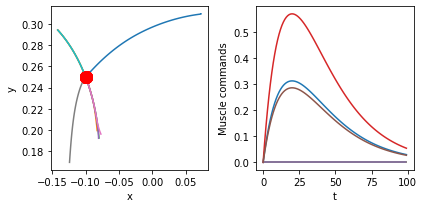

In [3]:
# Plot some random arm trajectories

n_steps = 100  # number of time steps

plt.figure(figsize=(6,3))
plt.subplot(121)

for ii in range(10):
    arm = Arm()
    z_traj = np.zeros((0,2))
    u0 = np.random.choice([0,1], 6)*np.random.rand(6)
    ut = 10*np.outer(np.exp(-5*np.arange(n_steps)/n_steps)*np.arange(n_steps)/n_steps, u0)
    for tt in range(n_steps):
        arm.forward(ut[tt])
        z_traj = np.append(z_traj, [arm.z], axis=0)

    plt.plot(z_traj[:,0], z_traj[:,1])
    plt.plot(-0.1, 0.25, 'or', ms=12)
    plt.xlabel('x')
    plt.ylabel('y')

# Plot the muscle commands from the last arm trajectory.
plt.subplot(122)
plt.plot(ut)
plt.xlabel('t')
plt.ylabel('Muscle commands')
plt.tight_layout()